In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import re
import torch

from torchvision import transforms
from keras.models import load_model
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import re
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification

In [ ]:
df_t = pd.read_json('/content/drive/MyDrive/semeval/annotations/data/subtask2b/train.json')
ind=df_t[df_t["image"]=="prop_meme_24871.png"].index
ind

Int64Index([34], dtype='int64')

In [ ]:
df = pd.read_json('/content/drive/MyDrive/semeval/annotations/data/subtask2b/train.json')
df=df[df["image"]!="prop_meme_24871.png"]
df_val= pd.read_json('/content/drive/MyDrive/semeval/annotations/data/subtask2b/val.json')
train_path="/content/drive/MyDrive/semeval/subtask2b_images/train"
val_path="/content/drive/MyDrive/semeval/subtask2b_images/val"

In [ ]:

def clean_text(df, text_column):
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in the DataFrame.")

    # Define the cleaning function
    def clean_single_text(text):
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
        cleaned_text = cleaned_text.lower()
        return cleaned_text
    df[text_column] = df[text_column].astype(str).apply(clean_single_text)

    return df

In [ ]:
df=clean_text(df,"text")
df_val=clean_text(df_val,"text")

In [ ]:
possible_labels = ["non_propagandistic","propagandistic"]
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'non_propagandistic': 0, 'propagandistic': 1}

In [ ]:
df['label'] = df.label.replace(label_dict)
df.head()

,id,text,image,label
0,35807,donald trump baracknobama and joe bidennwill b...,prop_meme_6570.png,1
1,30562,n fornthe big guynnancysncutnimmementhon fornt...,prop_meme_8346.png,1
2,44163,to much political posting onlinenthese days so...,prop_meme_24378.png,0
3,24224,i dont thinknyou understoodnwhat i saidnyou do...,prop_meme_2594.png,1
4,31611,sergey mihailicenkoanadolu agency via getty im...,prop_meme_7654.png,1


In [ ]:
df_val['label'] = df_val.label.replace(label_dict)
df_val.head()

,id,text,image,label
0,46916,thank younfor signing thenterm limits onncongr...,prop_meme_15428.png,0
1,35775,sp rises to recordnhigh passesnprepandemicnfi...,prop_meme_6538.png,1
2,44838,comradetynthe lefts new logonturningnpoint usa...,prop_meme_19807.png,1
3,41835,my friendshipncircle through my lifenteenagern...,prop_meme_16370.png,0
4,46179,ournpresidentnisnnawesomenpresidentnthensagenpage,prop_meme_18868.png,1


In [ ]:
df.label.value_counts()

1    800
0    399
Name: label, dtype: int64

In [ ]:

df.head()

,id,text,image,label
0,35807,donald trump baracknobama and joe bidennwill b...,prop_meme_6570.png,1
1,30562,n fornthe big guynnancysncutnimmementhon fornt...,prop_meme_8346.png,1
2,44163,to much political posting onlinenthese days so...,prop_meme_24378.png,0
3,24224,i dont thinknyou understoodnwhat i saidnyou do...,prop_meme_2594.png,1
4,31611,sergey mihailicenkoanadolu agency via getty im...,prop_meme_7654.png,1


## Training/Validation Split

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
df.index.values

array([   0,    1,    2, ..., 1197, 1198, 1199])

In [ ]:
X_train,y_train =df.index.values,df.label.values
X_val, y_val=df_val.index.values,df_val.label.values


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df["text"].astype(str),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df.label.values)

encoded_data_val = tokenizer.batch_encode_plus(
    df_val["text"].astype(str),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_val.label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train)

1199

In [ ]:
len(dataset_val)

150

## Setting up BERT Pretrained Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Creating Data Loaders

In [ ]:
batch_size = 32

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    print(f'Accuracy:')
    print(accuracy_score (labels_flat,preds_flat))
    conf_matrix = confusion_matrix(labels_flat,preds_flat)

# Display the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['-non-Prop', 'Prop'], yticklabels=['non-Prop', 'Prop'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def true_preds(preds):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    return preds_flat

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+4)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.pth')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5905493584118391
Validation loss: 0.5729171156883239
F1 Score (Weighted): 0.724223602484472


Epoch 2:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.541527984957946
Validation loss: 0.5565907955169678
F1 Score (Weighted): 0.712962962962963


Epoch 3:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5148269487054724
Validation loss: 0.5518819630146027
F1 Score (Weighted): 0.7073803632852573


Epoch 4:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5102202406055049
Validation loss: 0.5518819630146027
F1 Score (Weighted): 0.7073803632852573


Epoch 5:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5200404971837997
Validation loss: 0.5518819630146027
F1 Score (Weighted): 0.7073803632852573


Epoch 6:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.5220518449419423
Validation loss: 0.5518819630146027
F1 Score (Weighted): 0.7073803632852573


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
model.summary()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_6.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

Accuracy:
0.74


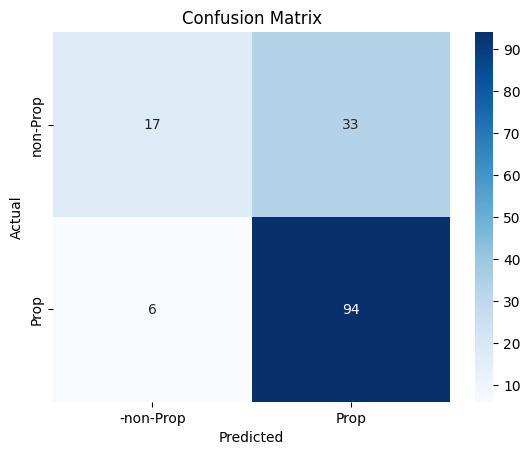

In [ ]:
accuracy_per_class(predictions, df["label"].values)

In [ ]:
_, predictions, true_vals = evaluate(dataloader_train)


In [ ]:


# Load the pre-trained PyTorch text modelte
text_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


text_model.load_state_dict(torch.load('/content/drive/MyDrive/semeval/model/finetuned_BERT_epoch_6.pth'))
text_model.to(device)
text_model.eval()

# Load the pre-trained Keras image model
image_model = load_model('/content/drive/MyDrive/semeval/model/model_eight_final.h5')

# Preprocess input data


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict_text(model_text, df):
    encoded_data_train = tokenizer.batch_encode_plus(
        df["text"].astype(str),
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df.label.values)
    dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=32)

    # Model evaluation
    model_text.eval()

    loss_total = 0
    predictions, true_vals = [], []

    for batch in dataloader:
        input_ids = batch[0].to("cuda")
        attention_mask = batch[1].to("cuda")
        labels = batch[2].to("cuda")

        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
        }


        with torch.no_grad():
            outputs = model_text(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_avg = loss_total / len(dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    #preds_flat = np.argmax(predictions, axis=1).flatten()

    return predictions

def predict_image(model_image, image_folder, df):
    predictions_img = []

    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    for _, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image'])  # Adjust 'image_column' based on your DataFrame
        image = Image.open(image_path).convert("RGB")
        image = image_transform(image)

        # Convert image to PyTorch tensor and add batch dimension
        image = image.unsqueeze(0)
        image = image.permute(0, 2, 3, 1)

        # Get probabilities from Keras image model (assuming model_image is loaded and defined)
        image_np = image.numpy()
        image_probs = model_image.predict(image_np)

        predictions_img.append(image_probs)

    # Convert list of arrays to a numpy array
    predictions_img = np.concatenate(predictions_img, axis=0)


    return predictions_img

def final_predict(image_preds, text_preds):

    final_probs=(0.3*image_preds)+(0.7*text_preds)
    final_probs/=2
    preds_flat = np.argmax(final_probs, axis=1).flatten()
    return preds_flat

def softmax(logits):
    exp_logits = np.exp(logits)
    probabilities = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
    return probabilities

In [ ]:
text_preds_train=predict_text(text_model,df)

In [ ]:

image_preds_train=predict_image(image_model,train_path,df)

1/1 [==============================] - 0s 33ms/step


In [ ]:
image_probs_train = np.concatenate([1-image_preds_train, image_preds_train], axis=1)
text_probs_train=softmax(text_preds_train)
txt=text_probs_train


In [ ]:
text_probs_train.shape

(1199, 2)

In [ ]:
final_preds_train=final_predict(image_probs_train,text_probs_train)

In [ ]:
accuracy_train=accuracy_score(final_preds_train,df["label"].values)
f1_train=f1_score(final_preds_train,df["label"].values)
precision_train=precision_score(final_preds_train,df["label"].values)
recall_train=recall_score(final_preds_train,df["label"].values)
accuracy_train,f1_train,precision_train,recall_train


(0.7589658048373644, 0.8362606232294617, 0.9225, 0.7647668393782383)

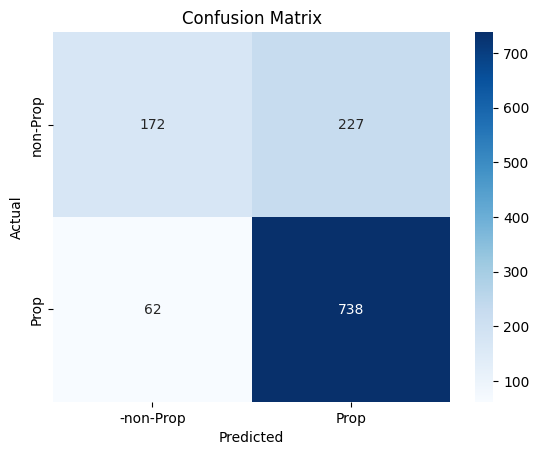

In [ ]:
conf_matrix = confusion_matrix(df["label"].values,final_preds_train)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['-non-Prop', 'Prop'], yticklabels=['non-Prop', 'Prop'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
text_preds_val=predict_text(text_model,df_val)

image_preds_val=predict_image(image_model,val_path,df_val)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


In [ ]:
image_probs_val = np.concatenate([1-image_preds_val, image_preds_val], axis=1)
text_probs_val=softmax(text_preds_val)



In [ ]:
final_preds_val=final_predict(image_probs_val,text_probs_val)
final_preds_val[1]

1

In [ ]:
accuracy_val=accuracy_score(final_preds_val,df_val["label"].values)
f1_val=f1_score(final_preds_val,df_val["label"].values)
precision_val=precision_score(final_preds_val,df_val["label"].values)
recall_val=recall_score(final_preds_val,df_val["label"].values)
accuracy_val,f1_val,precision_val,recall_val


NameError: ignored

In [ ]:
preds_flat = np.argmax(text_probs_val, axis=1).flatten()
accuracy_score(df_val["label"].values,preds_flat),f1_score(df_val["label"].values,preds_flat),precision_score(df_val["label"].values,preds_flat),recall_score(df_val["label"].values,preds_flat)

(0.74, 0.8281938325991189, 0.7401574803149606, 0.94)

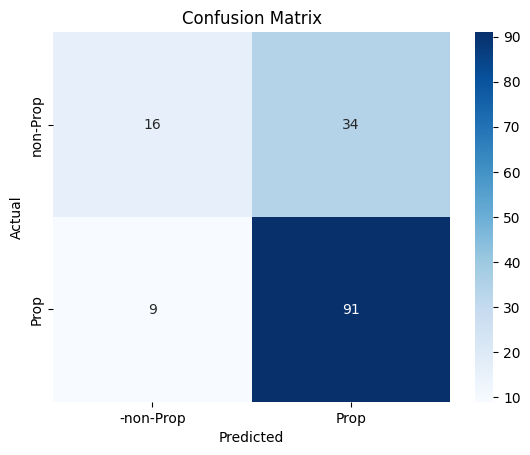

In [ ]:
conf_matrix = confusion_matrix(df_val["label"].values,final_preds_val)

# Display the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['-non-Prop', 'Prop'], yticklabels=['non-Prop', 'Prop'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()